마켓켑과 볼륨이 얼마나 상관성이 높을지?

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm

from tools_ryu import mytool
from multi_run_v3.data_pp import DataPreprocess

In [2]:
data = pd.read_pickle("Data/cmktcap_data_final.pickle")

data_pp = DataPreprocess()
data_pp.initialize(data=data)
data_pp.make_mask(mktcap_thresh=1_000_000,
                  vol_thresh=1_000_000,
                  ma=True)

In [3]:
price_pp = pd.read_pickle("close_pp.pickle")
mktcap_pp = pd.read_pickle("mktcap_pp.pickle")

### Volume을 Plot 해보자

In [4]:
vol.sum(1).sort_values(ascending=False)

date
2022-05-06    1.422843e+12
2021-02-26    9.055547e+11
2021-05-19    7.430338e+11
2022-01-20    7.413205e+11
2021-05-13    6.319318e+11
                  ...     
2013-10-04    0.000000e+00
2013-10-03    0.000000e+00
2013-10-02    0.000000e+00
2013-10-01    0.000000e+00
2013-04-28    0.000000e+00
Length: 3641, dtype: float64

In [5]:
vol.loc["2022-05-06"].sort_values(ascending=False)
# 2469,Zilliqa,ZIL
# 2396,WETH,WETH

# 테더(825)랑 BTC(1)보다 거래량이 많을 수 있나?

coin_id
2469    6.131225e+11
2396    6.074926e+11
825     8.132788e+10
1       3.779558e+10
1027    2.102760e+10
            ...     
995              NaN
996              NaN
997              NaN
998              NaN
999              NaN
Name: 2022-05-06 00:00:00, Length: 10616, dtype: float64

In [6]:
vol[["2469"]].loc["2022-05-04":"2022-05-08"]

coin_id,2469
date,
2022-05-04,1.093958e+09
2022-05-05,1.561508e+09
2022-05-06,6.131225e+11
2022-05-07,5.857890e+08
2022-05-08,4.441770e+08


In [7]:
vol[["2396"]].loc["2022-05-04":"2022-05-08"]

coin_id,2396
date,
2022-05-04,1.794877e+09
2022-05-05,1.861418e+09
2022-05-06,6.074926e+11
2022-05-07,1.132169e+09
2022-05-08,1.971881e+09


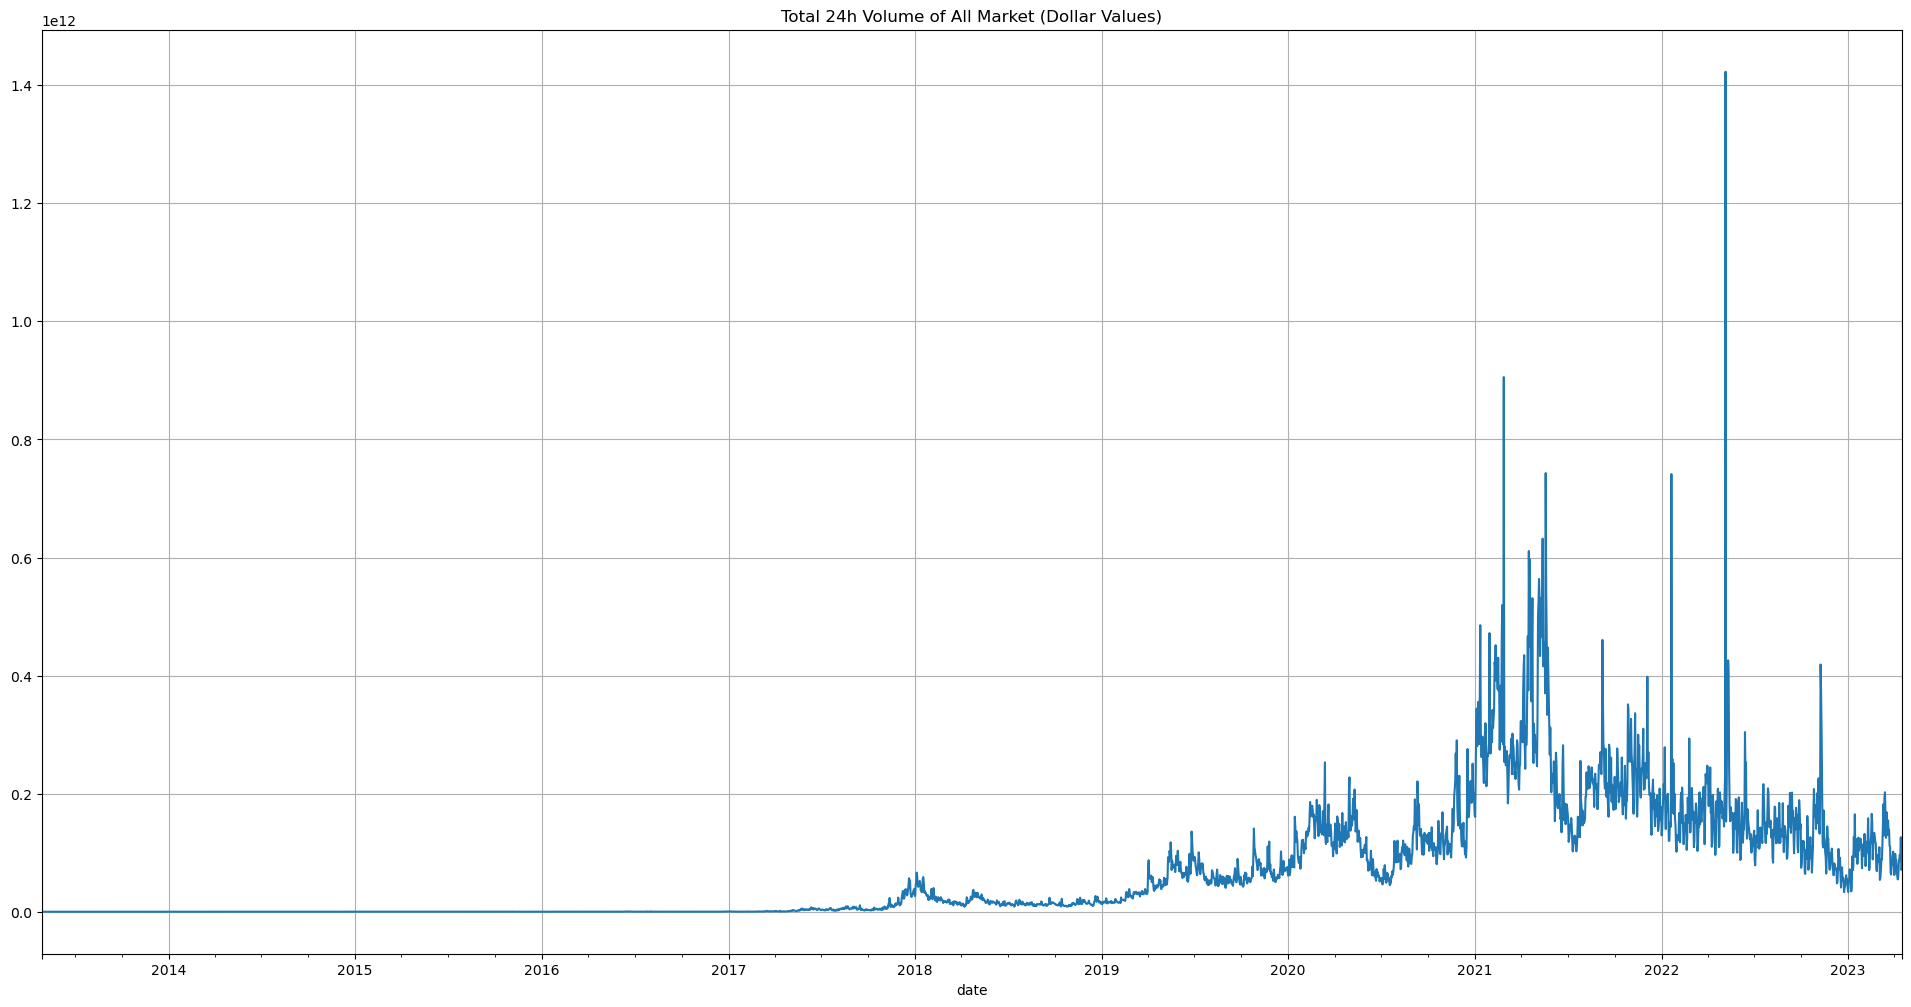

In [8]:
(vol.sum(1)).plot(figsize=(24,12))
plt.title("Total 24h Volume of All Market (Dollar Values)")
plt.grid();

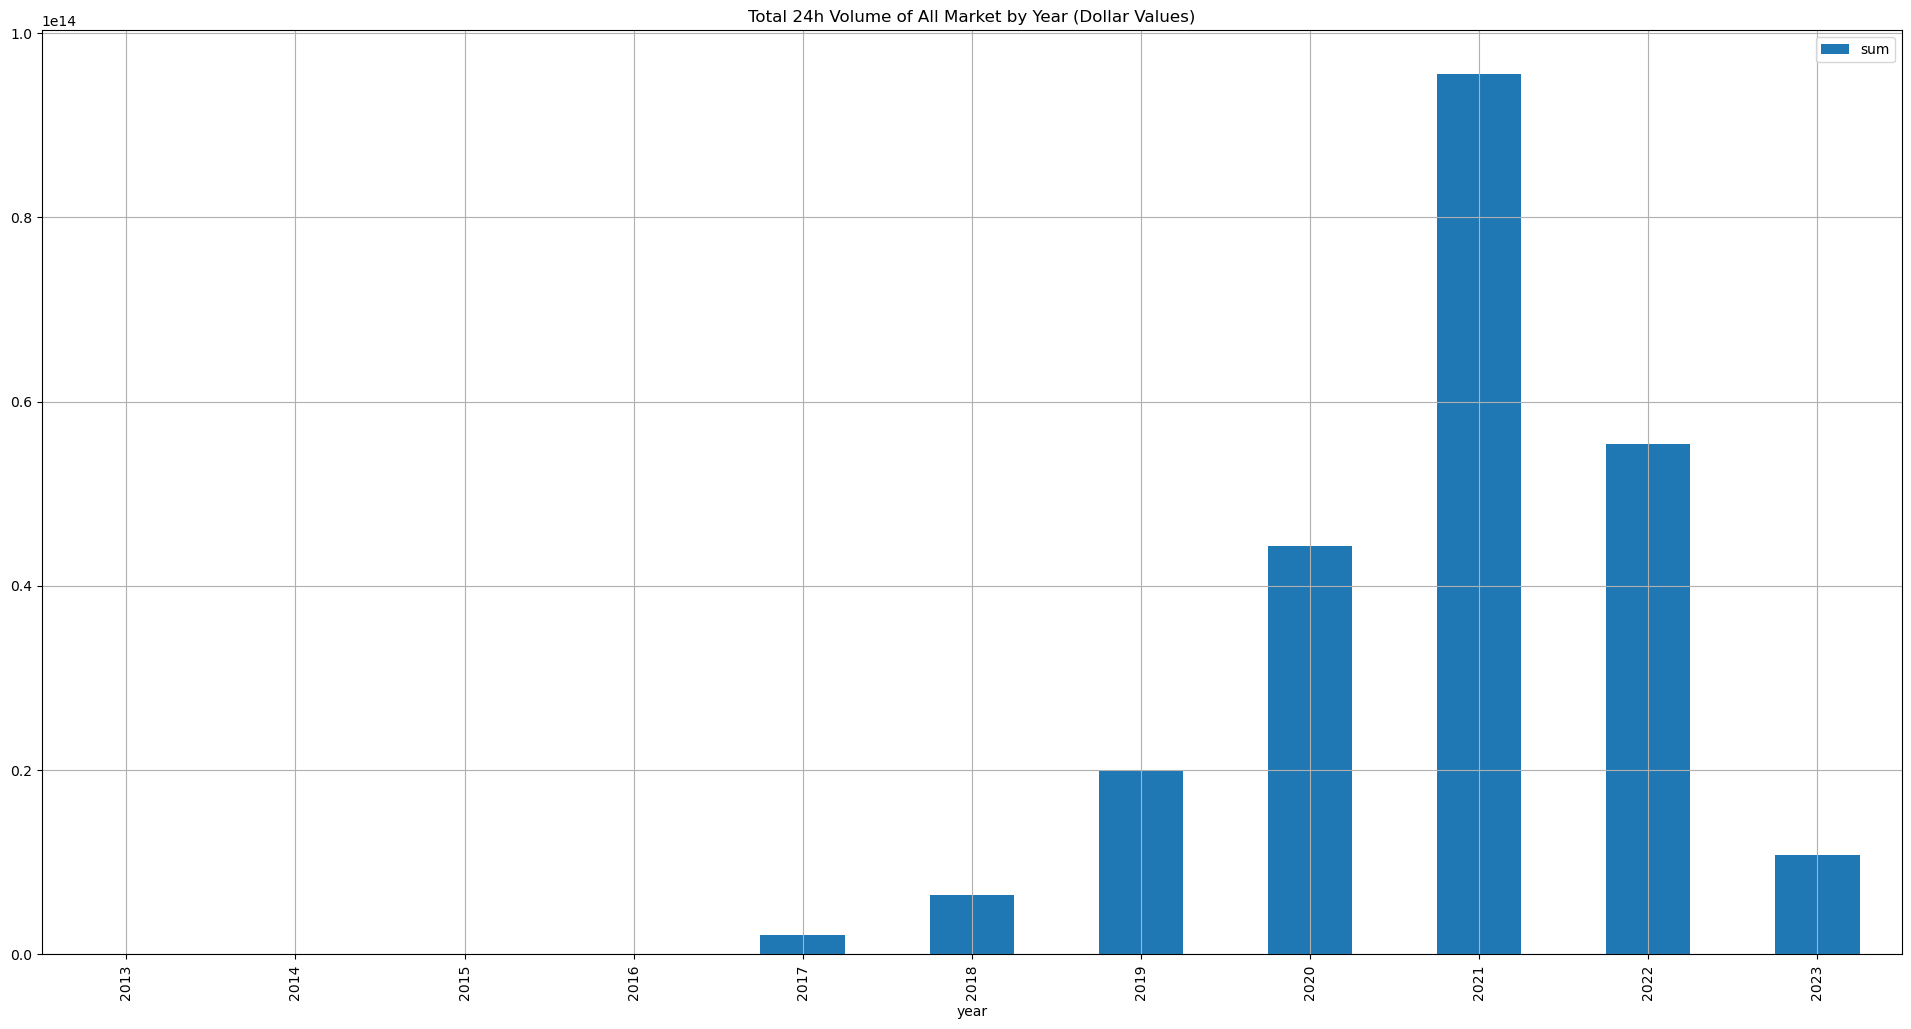

In [9]:
mean = pd.DataFrame(vol.sum(1), columns=["sum"])
mean["year"] = mean.index.year

mean.groupby("year")[["sum"]].sum().plot(kind="bar", figsize=(24,12))
plt.title("Total 24h Volume of All Market by Year (Dollar Values)")
plt.grid();

In [10]:
mean.groupby("year")[["sum"]].sum()#.quantile(0.2)

,sum
year,
2013,2.340629e+08
2014,1.325842e+10
2015,1.488553e+10
2016,4.531403e+10
2017,2.055896e+12
2018,6.448566e+12
2019,1.997269e+13
2020,4.432740e+13
2021,9.555799e+13


In [11]:
# 연도별 코인 수 찾기 (Volume이 존재하는...)
for year in ["2013","2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]:
    numbers = (len(vol.columns) - vol.loc[year].isna().sum(1)).max()
    tmp_mktcap = vol.loc[year]

    if year == "2013":
        print("year", "Number")
    print(year, numbers)

year Number
2013 58
2014 484
2015 536
2016 573
2017 968
2018 929
2019 1255
2020 2150
2021 2724
2022 8026
2023 9195


### Volume 1_000_000 이상 마스킹

In [12]:
# 거래량이 0이상 찍힌 애들만 남겨보자
vol_mask = (vol > 1_000_000).replace({True:1,
                              False:np.nan})

mktcap_pp = mktcap * vol_mask #거래량이 0이니까 그냥 오늘 빼도 될듯
vol_pp = vol * vol_mask

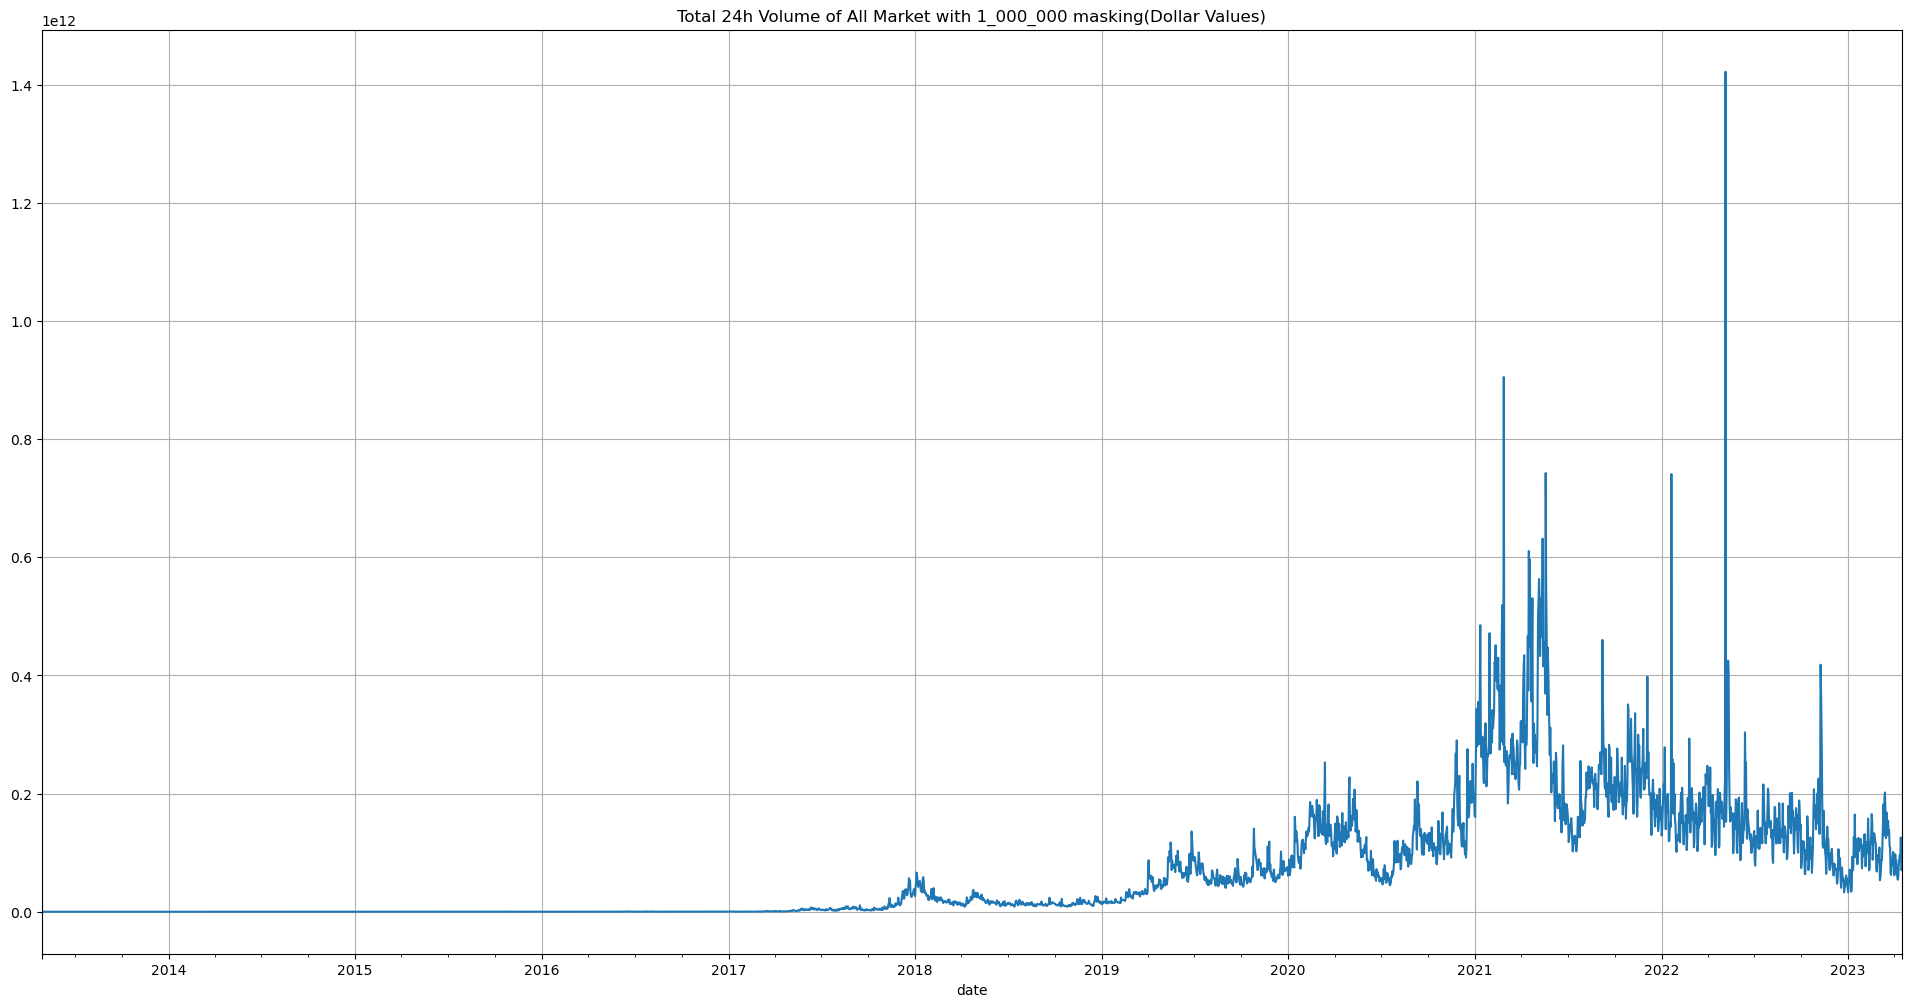

In [13]:
(vol_pp.sum(1)).plot(figsize=(24,12))
plt.title("Total 24h Volume of All Market with 1_000_000 masking(Dollar Values)")
plt.grid();

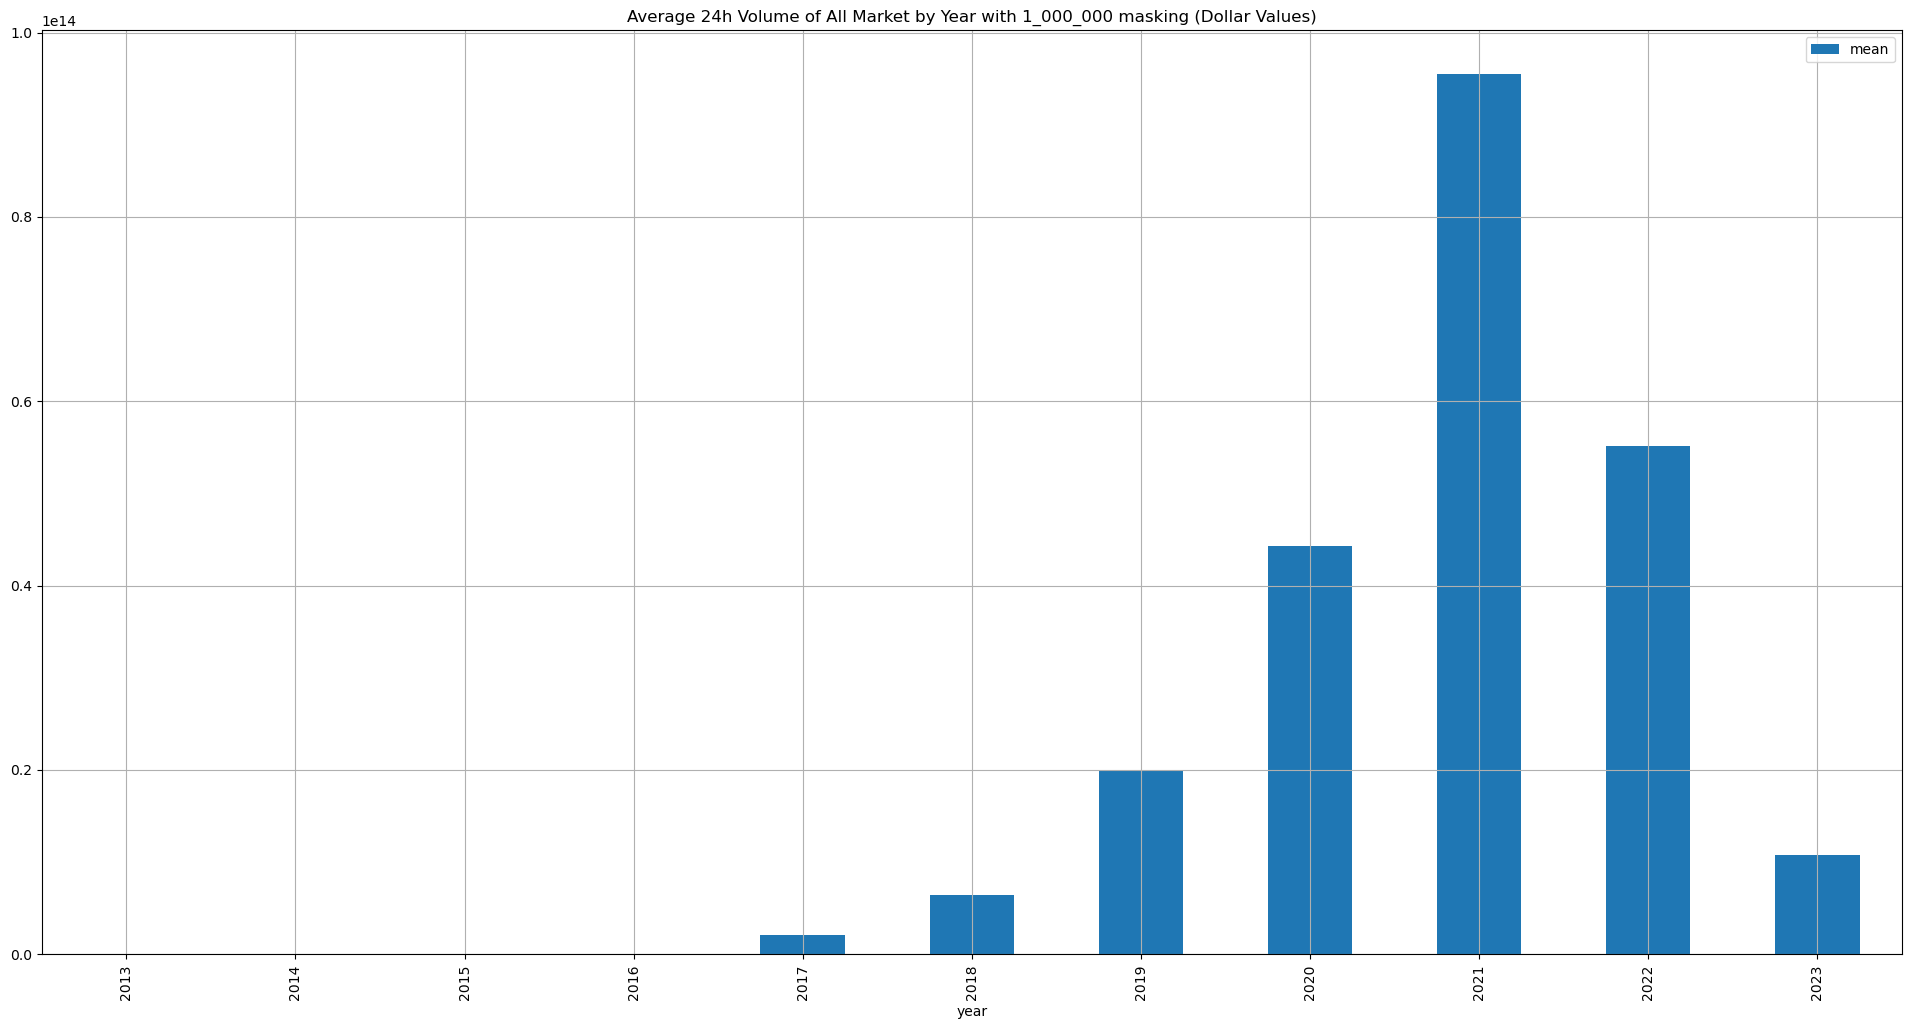

In [14]:
mean = pd.DataFrame(vol_pp.sum(1), columns=["mean"])
mean["year"] = mean.index.year

mean.groupby("year")[["mean"]].sum().plot(kind="bar", figsize=(24,12))
plt.title("Average 24h Volume of All Market by Year with 1_000_000 masking (Dollar Values)")
plt.grid();

In [15]:
mean.groupby("year")[["mean"]].sum()

,mean
year,
2013,2.185048e+08
2014,1.219054e+10
2015,1.416986e+10
2016,4.307090e+10
2017,2.045036e+12
2018,6.422183e+12
2019,1.993960e+13
2020,4.427577e+13
2021,9.547629e+13


In [16]:
# 연도별 코인 수 찾기 (Volume이 존재하는...)
for year in ["2013","2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]:
    numbers = (len(vol_pp.columns) - vol_pp.loc[year].isna().sum(1)).max()
    tmp_mktcap = vol_pp.loc[year]

    if year == "2013":
        print("year", "Number")
    print(year, numbers)

year Number
2013 3
2014 8
2015 7
2016 13
2017 215
2018 264
2019 290
2020 474
2021 863
2022 1130
2023 866


### 교수님께서 원하시는 우하향하는 Plot

최근 n년간 Volume이 m보다 큰 모든 코인 수의 총 합을 PLot

In [17]:
vol_ma30 = vol.rolling(window=30).mean()
return_dict = {}

for year in tqdm(["2018","2019","2020","2021","2022","2023"]):
    lst = []
    for value in [0,100_000,500_000,1_000_000,3_000_000,7_000_000, 10_000_000, 30_000_000, 70_000_000, 100_000_000]:
        vol_mask = vol[vol_ma30 > value].loc[year]
        find = vol_mask.dropna(axis=1, thresh=1).shape[1] #한번이라도 해당 년도에 포함되면 코인 수에 포함 함
        lst.append(find)
    return_dict[year] = lst

100%|██████████| 6/6 [01:11<00:00, 11.87s/it]


In [23]:
return_dict

{'2018': [913, 638, 498, 427, 313, 232, 200, 105, 51, 40],
 '2019': [1244, 721, 515, 439, 312, 205, 175, 81, 42, 35],
 '2020': [2044, 1230, 892, 734, 512, 357, 291, 142, 82, 68],
 '2021': [2465, 1709, 1361, 1192, 863, 665, 582, 411, 282, 226],
 '2022': [7777, 4383, 2600, 1895, 1141, 756, 647, 375, 226, 170],
 '2023': [8392, 2976, 1531, 1083, 651, 479, 414, 223, 116, 79]}

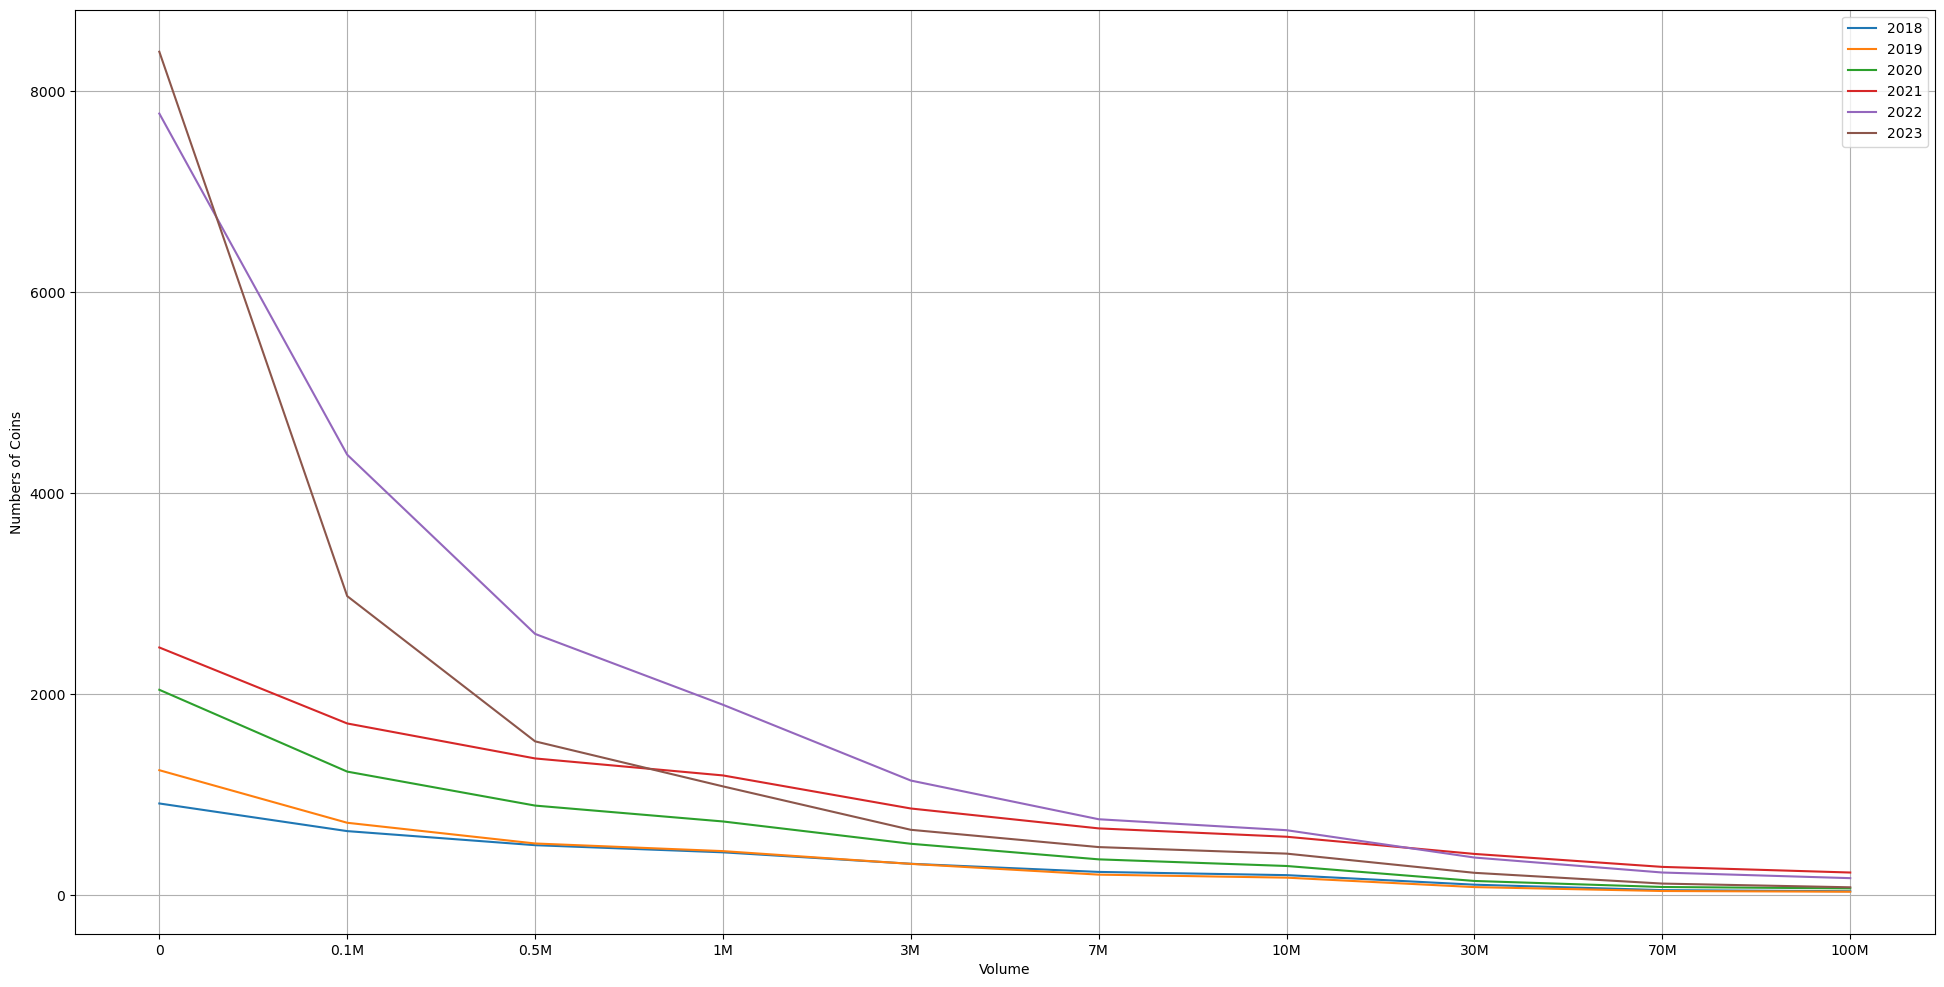

In [24]:
# 그림으로 그리기
plt.figure(figsize=(24,12))
plt.grid()
plt.xlabel("Volume")
plt.ylabel("Numbers of Coins")

for key, list in return_dict.items():
    plt.plot(range(len(list)), list, label=key)
    plt.xticks(range(len(list)),
               ["0","0.1M","0.5M","1M","3M","7M","10M","30M","70M","100M"])
    plt.legend()

이미 그렸던 넘버 오브 코인이 어떻게 증가하는지 (시간에 따라) + 마켓켑 + 전체 마켓의 트레이딩 볼륨 -> 3개를 한꺼번에
           -> 이 3개 그래프는 (마켓켑은 로그X), 개수랑 마켓켑을 넣으면 y축을 두개쓰면 되는데, 거래량은 따로 plot으로 빼야할 것 같음(그려보고 판단)

In [20]:
# price가 nan이 아니면 무조건 mktcap도 nan이 아님!
(price_pp.isna() == mktcap_pp.isna()).mean().mean()

0.8705948921342318

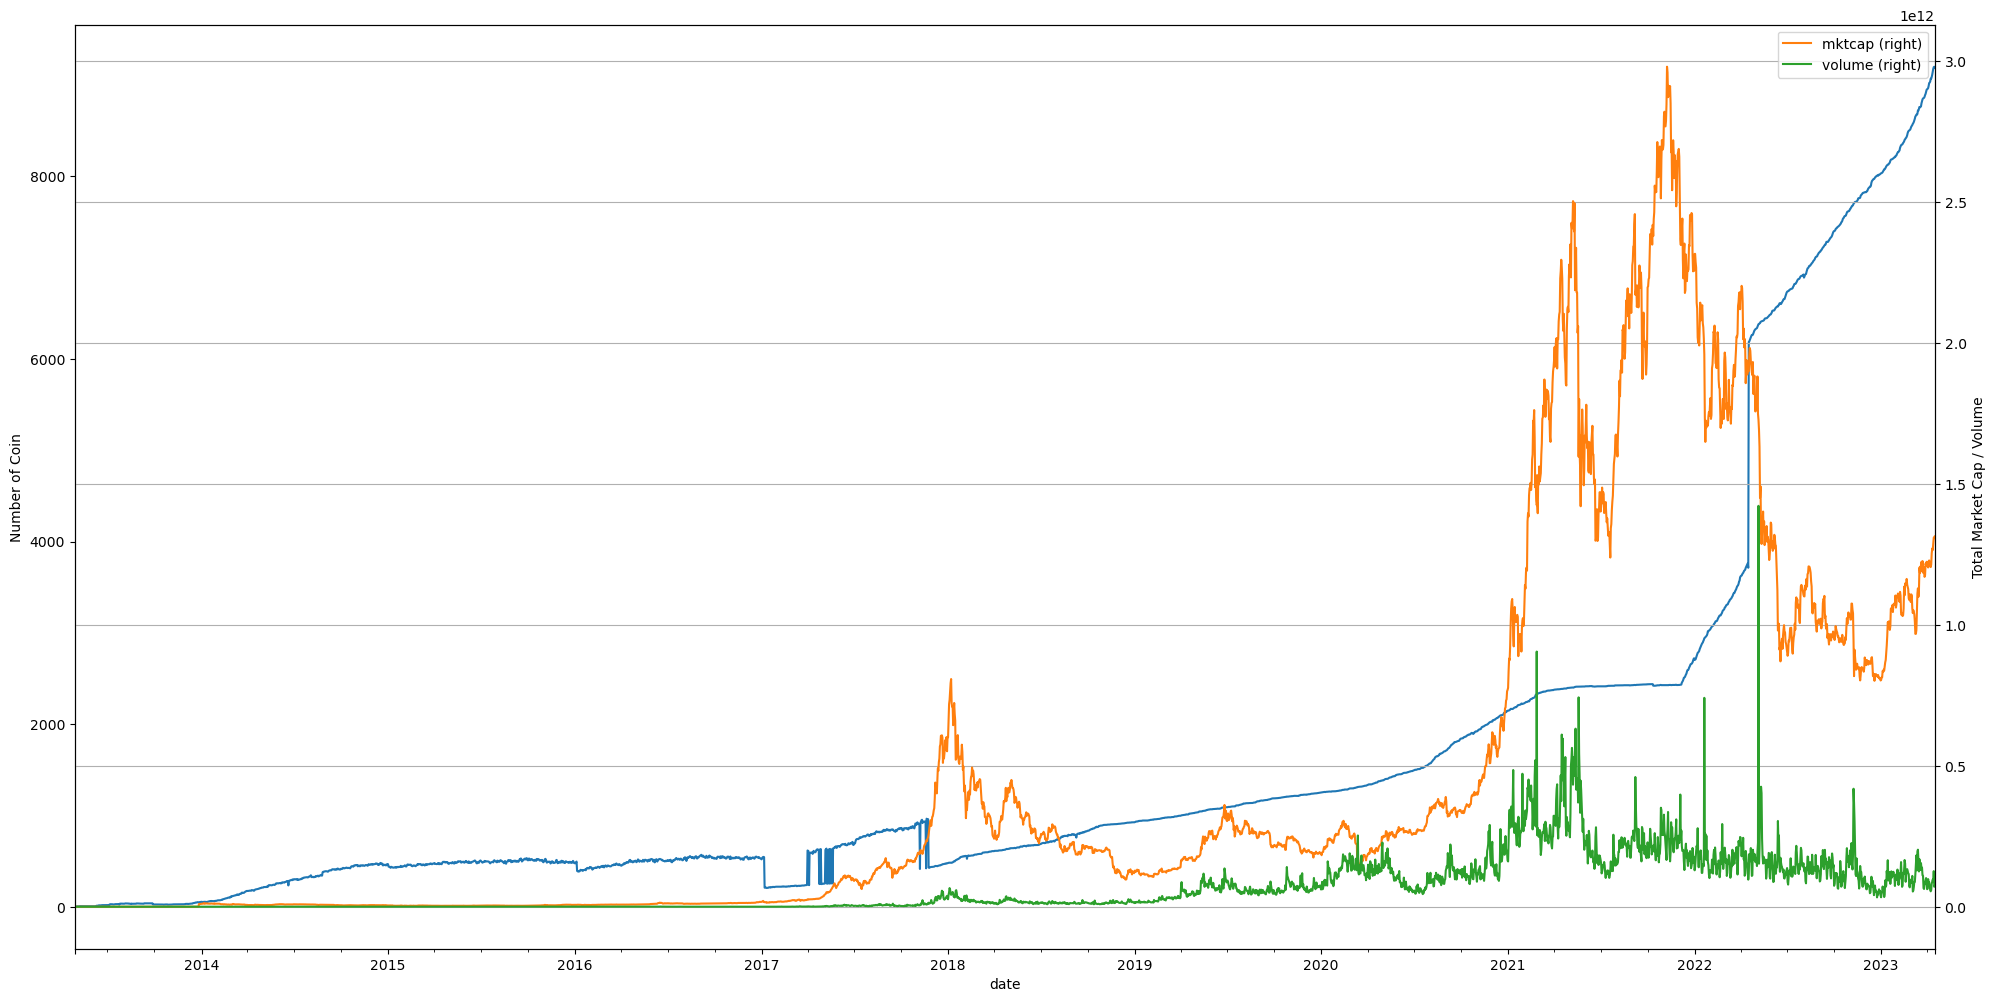

In [22]:
fig, ax = plt.subplots(1,1)
price_pp.replace(0, np.nan).count(1).plot(figsize=(24,12), ax=ax, ylabel="Number of Coin", label="Num of coin")
mktcap_pp.sum(1).plot(ax=ax, secondary_y=True, ylabel="Total Market Cap / Volume", label="mktcap")
vol.sum(1).plot(ax=ax, secondary_y=True, label="volume")
plt.legend()
plt.grid();